# Training patches preparation

In [1]:
import sys
sys.path.insert(0, "..")
import matplotlib.pyplot as plt
from PIL import Image
import json

from dataloader import *
from lib import *
from model import *

In [2]:
with open(PATH_PARAMETERS) as f:
    params = json.load(f)
params = params['models_settings']

### Explore dataset

In [3]:
file_names = get_image_names()   
# print(file_names) 
labels = list_labels(file_names)
size_ranges = get_sizes(file_names)

print(f'labels in dataset : {labels}')
print(f'size ranges : {size_ranges}')

labels in dataset : {'_background_', 'flagellum', 'head'}
size ranges : {'h-range': [512, 512], 'w-range': [512, 512]}


In [4]:
images = load_images(file_names)
masks = load_masks(file_names)

image shape =  (512, 512, 3)
mask shape =  (512, 512, 3)


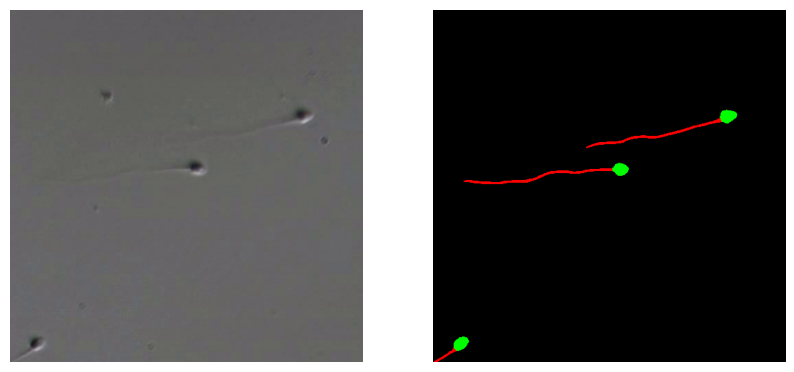

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(images[0], cmap='gray')
ax[0].axis('off')
ax[1].imshow(masks[0])
ax[1].axis('off')
print('image shape = ', images[0].shape)
print('mask shape = ', masks[0].shape)

### Patch extraction

In [7]:
# number of patches per image (should depend on patch and image size)
n = 20

shape_to_label = params['label_to_value']
label_to_shape = {v:k for k,v in shape_to_label.items()}
d_pixels = {k:0 for k in shape_to_label.keys()}
d_images = {k:0 for k in shape_to_label.keys()}
feature_labels = set([v for k,v in shape_to_label.items() if k!='_background_'])

data = []

for img,mask in zip(images,masks):
    mask = rgb2mask(mask)
    patches, patch_masks = random_patches(img, mask, n=n, patch_h=params['patch_height'], patch_w=params['patch_width'])
    for patch, patch_mask in zip(patches,patch_masks):
        # consider only patch containing feature_labels
        if len(set(np.unique(patch_mask)).intersection(feature_labels))>0:  
            data.append((patch, patch_mask))
            
            count = Counter(patch_mask.flatten().tolist())
            for label, num in count.most_common():
                d_pixels[label_to_shape[label]] += num
                d_images[label_to_shape[label]] += 1
                
print('pixel per class = ', d_pixels)
print('images per class = ', d_images)
                
data_aug = augment_rectangular(data)      
random.shuffle(data_aug)
    
F = [val/(d_images[key]*patch_mask.size) for key,val in d_pixels.items()]
w = np.median(F)/F
print('cross entropy loss class weights = ', w)

pixel per class =  {'_background_': 25571248, 'flagellum': 463159, 'head': 212761}
images per class =  {'_background_': 1602, 'flagellum': 1491, 'head': 779}
cross entropy loss class weights =  [0.01946091 1.         1.13735987]


(128, 128, 3) (128, 128)


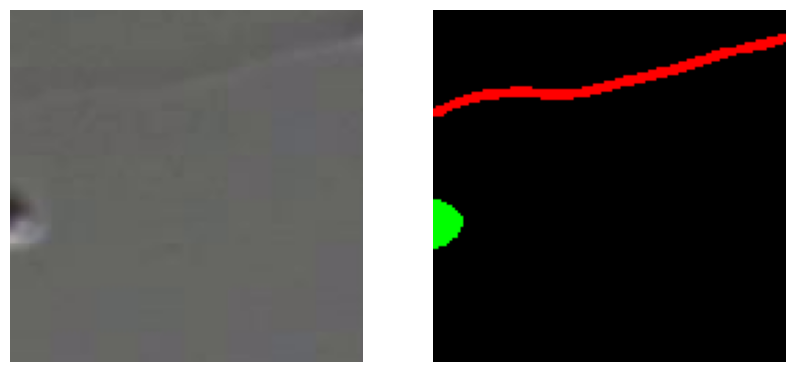

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(data[1][0], cmap='gray')
ax[0].axis('off')
ax[1].imshow(mask2rgb(data[1][1]))
ax[1].axis('off')
print(patch.shape, patch_mask.shape)

In [15]:
export_dir = '../data/patches_s128'
save_patches(export_dir, data_aug)

### Visualize patches

In [16]:
tile_size = (256, 128)

path_images = natsort.natsorted(glob(os.path.join(export_dir, 'images', '*.png')))
path_masks = natsort.natsorted(glob(os.path.join(export_dir, 'masks', '*.png')))

# fix plot to accept npy array input or save mask properl as an image
complete_image = compose_image(path_images, path_masks, tile_size, n=3)

0 1024


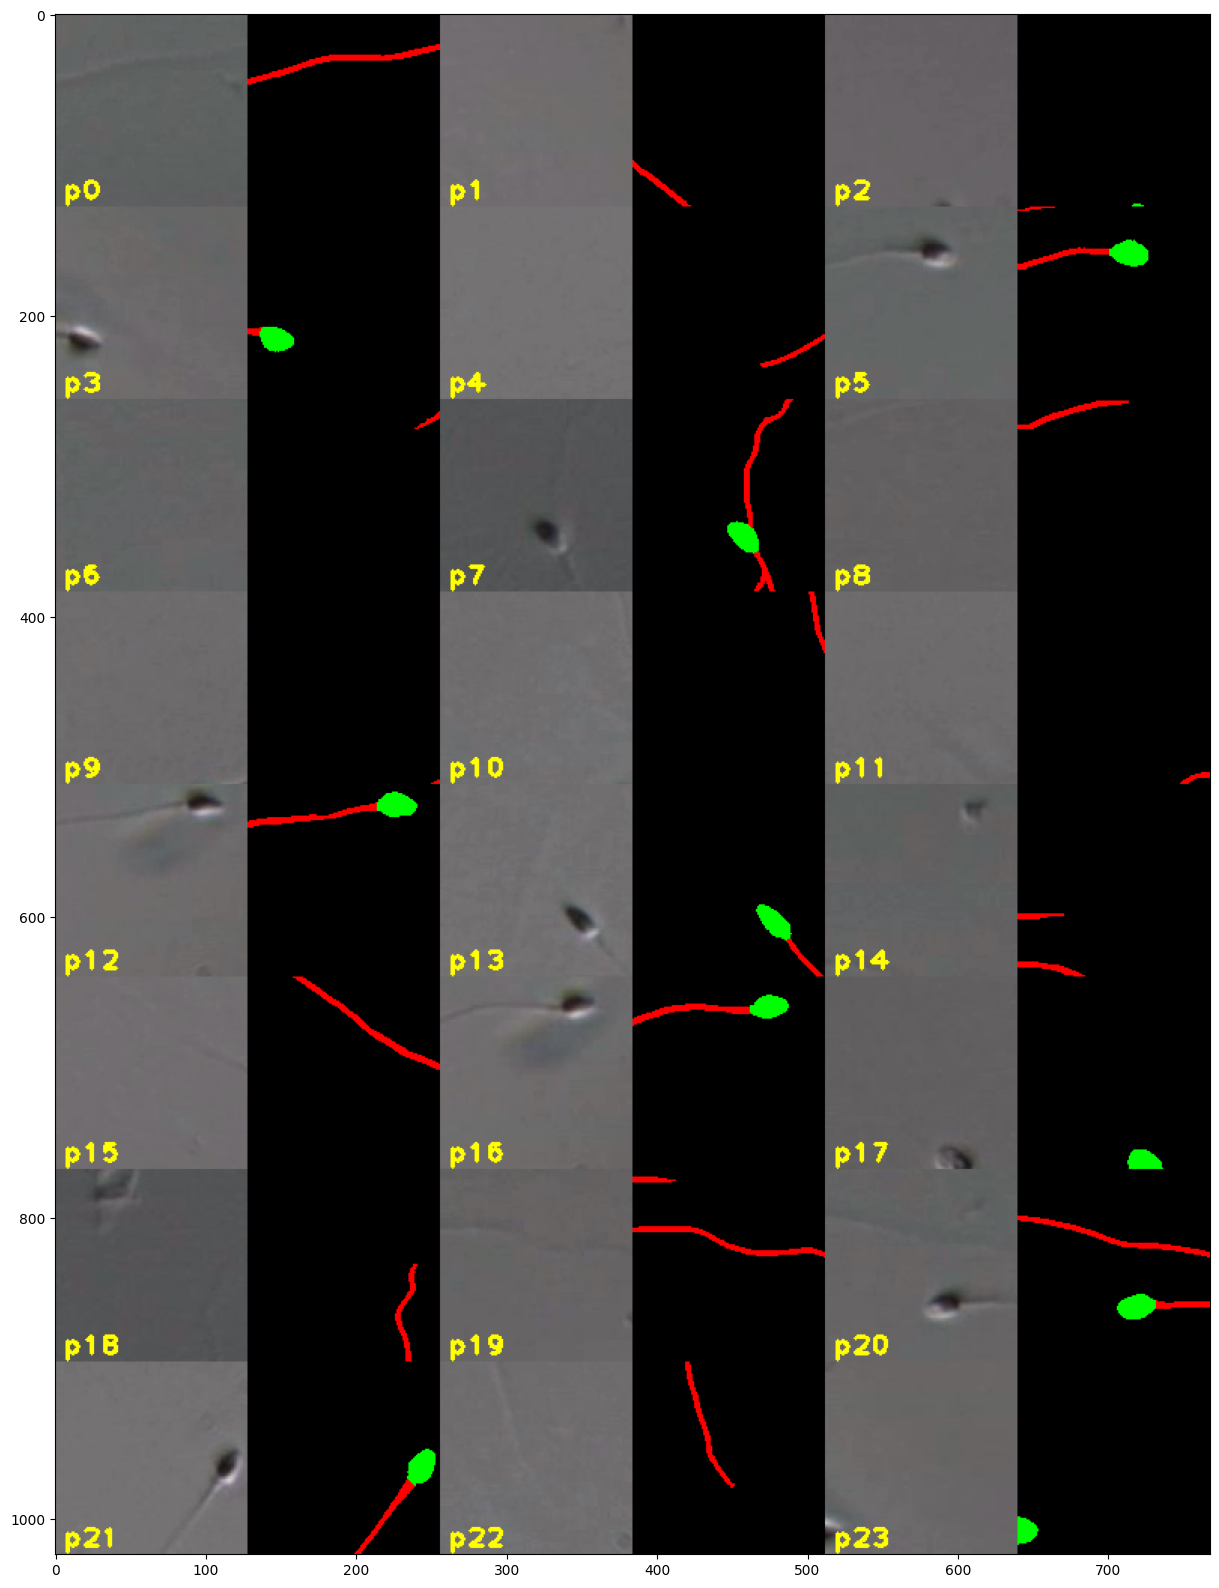

In [17]:
plot_patches(complete_image, tile_size, index=0)

### Test model training iteration

In [18]:
batch_size = 4
val_ratio = 0.2
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4}
train_loader, val_loader =  make_dataloaders(export_dir, val_ratio, params)

In [19]:
it = iter(train_loader)
sample = next(it)
imgs = sample['image']
true_masks = sample['mask']
print(imgs.size())
print(true_masks.size())

torch.Size([4, 3, 128, 128])
torch.Size([4, 128, 128])


In [14]:
net = UNet(n_channels=3, n_classes=3)
# net.cuda()
net.eval()
outputs = net(imgs)

/dih4/dih4_1/summercamp/agolisowicz/CA_summarization/my_venv/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
a,b = eval_net_loader(net, val_loader, 3)
print('Class IoU:', ' '.join(f'{x:.3f}' for x in a), f'  |  Mean IoU: {b:.3f}')

(-0.5, 127.5, 127.5, -0.5)

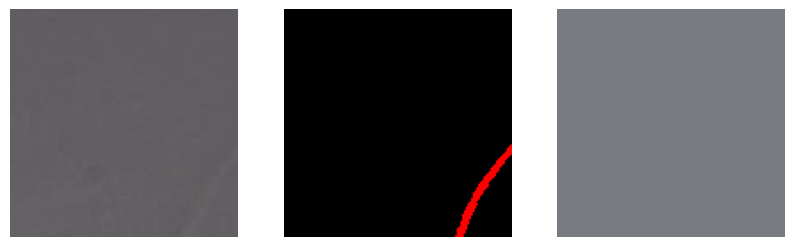

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(10, 8))
ax[0].imshow(np.transpose(imgs[0], (1,2,0)))
ax[0].axis('off')
ax[1].imshow(mask2rgb(true_masks[0].detach().numpy()))
ax[1].axis('off')
ax[2].imshow(np.transpose(outputs[0].detach().numpy(),(1,2,0)))
ax[2].axis('off')